# Import Libraries

In [1]:
import os
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

import cv2
import timm

import albumentations as A
from albumentations import (
    Compose, OneOf, Normalize, CenterCrop, Resize, RandomResizedCrop, RandomCrop, HorizontalFlip, VerticalFlip, 
    RandomBrightness, RandomContrast, RandomBrightnessContrast, RandomRotate90, ShiftScaleRotate, Cutout, 
    IAAAdditiveGaussianNoise, Transpose, HueSaturationValue, CoarseDropout
    )
from albumentations.pytorch import ToTensorV2

import warnings
warnings.filterwarnings("ignore")

import logging
import time
from contextlib import contextmanager

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Directly Settings

In [2]:
DATA_DIR = '../input/plant-pathology-2021-fgvc8/'
TEST_DIR = DATA_DIR + 'test_images/'
TRAIN_DIR = DATA_DIR + 'train_images/'
TRAIN_CSV_DIR = DATA_DIR + 'train.csv'
TEST_CSV_DIR = DATA_DIR + 'sample_submission.csv'
train_df = pd.read_csv(TRAIN_CSV_DIR)
sub_df = pd.read_csv(TEST_CSV_DIR)

In [3]:
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [4]:
sub_df

,image,labels
0,85f8cb619c66b863.jpg,healthy
1,ad8770db05586b59.jpg,healthy
2,c7b03e718489f3ca.jpg,healthy


In [5]:
#TARGET = train_df['labels'].unique()
TARGET = ['image','healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex']
SUB_LABELS = ['image','labels']

TARGET

['image',
 'healthy',
 'scab frog_eye_leaf_spot complex',
 'scab',
 'complex',
 'rust',
 'frog_eye_leaf_spot',
 'powdery_mildew',
 'scab frog_eye_leaf_spot',
 'frog_eye_leaf_spot complex',
 'rust frog_eye_leaf_spot',
 'powdery_mildew complex',
 'rust complex']

# One hot encoding

In [6]:
train_df

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex
...,...,...
18627,fffb900a92289a33.jpg,healthy
18628,fffc488fa4c0e80c.jpg,scab
18629,fffc94e092a59086.jpg,rust
18630,fffe105cf6808292.jpg,scab frog_eye_leaf_spot


In [7]:
onehot_df = pd.get_dummies(train_df, columns=['labels'])
onehot_df

,image,labels_complex,labels_frog_eye_leaf_spot,labels_frog_eye_leaf_spot complex,labels_healthy,labels_powdery_mildew,labels_powdery_mildew complex,labels_rust,labels_rust complex,labels_rust frog_eye_leaf_spot,labels_scab,labels_scab frog_eye_leaf_spot,labels_scab frog_eye_leaf_spot complex
0,800113bb65efe69e.jpg,0,0,0,1,0,0,0,0,0,0,0,0
1,8002cb321f8bfcdf.jpg,0,0,0,0,0,0,0,0,0,0,0,1
2,80070f7fb5e2ccaa.jpg,0,0,0,0,0,0,0,0,0,1,0,0
3,80077517781fb94f.jpg,0,0,0,0,0,0,0,0,0,1,0,0
4,800cbf0ff87721f8.jpg,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18627,fffb900a92289a33.jpg,0,0,0,1,0,0,0,0,0,0,0,0
18628,fffc488fa4c0e80c.jpg,0,0,0,0,0,0,0,0,0,1,0,0
18629,fffc94e092a59086.jpg,0,0,0,0,0,0,1,0,0,0,0,0
18630,fffe105cf6808292.jpg,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
col = onehot_df.drop('image', axis=1)#変換したラベルを取得する
col

,labels_complex,labels_frog_eye_leaf_spot,labels_frog_eye_leaf_spot complex,labels_healthy,labels_powdery_mildew,labels_powdery_mildew complex,labels_rust,labels_rust complex,labels_rust frog_eye_leaf_spot,labels_scab,labels_scab frog_eye_leaf_spot,labels_scab frog_eye_leaf_spot complex
0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
18627,0,0,0,1,0,0,0,0,0,0,0,0
18628,0,0,0,0,0,0,0,0,0,1,0,0
18629,0,0,0,0,0,0,1,0,0,0,0,0
18630,0,0,0,0,0,0,0,0,0,0,1,0


In [9]:
TARGET_COLUMNS = col.columns.values
TARGET_COLUMNS

array(['labels_complex', 'labels_frog_eye_leaf_spot',
       'labels_frog_eye_leaf_spot complex', 'labels_healthy',
       'labels_powdery_mildew', 'labels_powdery_mildew complex',
       'labels_rust', 'labels_rust complex',
       'labels_rust frog_eye_leaf_spot', 'labels_scab',
       'labels_scab frog_eye_leaf_spot',
       'labels_scab frog_eye_leaf_spot complex'], dtype=object)

In [10]:
onehot_df[TARGET_COLUMNS].values

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [11]:
onehot_df.shape

(18632, 13)

In [12]:
DEBUG = True
if DEBUG:
    onehot_df = onehot_df.sample(frac = 0.1).reset_index(drop = True)
    print(onehot_df.shape)

(1863, 13)


# Config

In [13]:
CFG = {
    'model_arch': 'efficientnet_b4',
    'img_size': 320,
    'epochs': 5,
}

TARGET = ['image','healthy', 'scab frog_eye_leaf_spot complex', 'scab', 'complex',
       'rust', 'frog_eye_leaf_spot', 'powdery_mildew',
       'scab frog_eye_leaf_spot', 'frog_eye_leaf_spot complex',
       'rust frog_eye_leaf_spot', 'powdery_mildew complex',
       'rust complex']

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

@contextmanager
def timer(name, logger=None, level=logging.DEBUG):
    print_ = print if logger is None else lambda msg: logger.log(level, msg)
    t0 = time.time()
    print_(f'[{name}] start')
    yield
    print_(f'[{name}] done in {time.time() - t0:.0f} s')

# Split data

In [14]:
from sklearn.model_selection import train_test_split
train, valid =  train_test_split(onehot_df, test_size = 0.1)
print(train.shape, valid.shape)

(1676, 13) (187, 13)


# Dataset

All datasets that represent a map from keys to data samples should subclass it. All subclasses should overwrite __getitem__(), supporting fetching a data sample for a given key. Subclasses could also optionally overwrite __len__(), which is expected to return the size of the dataset by many Sampler implementations and the default options of DataLoader.

In [15]:
#pytorchのDatasetクラスを継承したクラスを作成する
class TrainDataset(Dataset):
    def __init__(self, onehot_df, transform = None): #初期化
        self.onehot_df = onehot_df
        self.image_names = onehot_df["image"].values
        self.labels = onehot_df[TARGET_COLUMNS].values
        self.transform = transform
        
#データの長さを返す関数
    def __len__(self):
        return len(self.onehot_df)
    
#indexに対応する画像とラベルを返す関数
    def __getitem__(self, idx):
        image_name = self.image_names[idx] #indexに対応するimageの値
        image_path = TRAIN_DIR + image_name #indexに対応するデータのパス
        image = cv2.imread(image_path) #画像読み込み
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) #BGR→RGB
        #label = self.labels[idx] #indexに対応するラベル
        label = torch.tensor(self.labels[idx]).float()
        if self.transform: #前処理ある場合
            augmented = self.transform(image=image)
            image = augmented['image']
        return image, label

In [16]:
class TestDataset(Dataset):
    def __init__(self, onehot_df, transform = None):
        self.onehot_df = onehot_df
        self.image_names = onehot_df["image"].values
        self.transform = transform
        
    def __len__(self):
        return len(self.onehot_df)
    
    def __getitem__(self, idx):
        image_name = self.image_names[idx]
        image_path = TEST_DIR + image_name
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        return image

# Transform

In [17]:
def get_transforms(*,data):
    
    if data == 'train':
        return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            RandomResizedCrop(CFG['img_size'], CFG['img_size'], scale=(0.85, 1.0)),
            HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.48, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])
    elif data == 'valid':
        return Compose([
            Resize(CFG['img_size'], CFG['img_size']),
            #RandomResizedCrop(600, 600, scale=(0.85, 1.0)),
            #HorizontalFlip(p=0.5),
            Normalize(
                mean=[0.48, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [18]:
# 上で作成したデータセットクラスを呼び出す
train_dataset = TrainDataset(onehot_df, transform = get_transforms(data = 'train'))
# データセットクラスによって取り出されるデータをbatch数でまとめる
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True, num_workers = 2, drop_last = True)
train_dataset[0]

(tensor([[[ 1.3974,  1.2604,  1.1576,  ...,  0.4384,  0.3356,  0.1473],
          [ 1.3974,  1.3118,  1.1405,  ...,  0.4898,  0.3699,  0.1815],
          [ 1.3974,  1.2946,  1.1748,  ...,  0.5240,  0.2329,  0.2671],
          ...,
          [ 1.0206,  0.9179,  0.8665,  ..., -0.2123, -0.2637, -0.1781],
          [ 1.0720,  1.0206,  0.9350,  ..., -0.1267, -0.0925, -0.2295],
          [ 1.1234,  1.0720,  1.0035,  ..., -0.2123, -0.1781, -0.1267]],
 
         [[ 2.2010,  2.1660,  2.0784,  ...,  1.3782,  1.2731,  1.1331],
          [ 2.2010,  2.2010,  2.0609,  ...,  1.4307,  1.3081,  1.1681],
          [ 2.1835,  2.1835,  2.0609,  ...,  1.3957,  1.2031,  1.2031],
          ...,
          [ 1.9034,  1.8158,  1.7633,  ...,  0.7654,  0.6954,  0.8179],
          [ 1.9209,  1.8859,  1.7458,  ...,  0.8529,  0.8529,  0.7129],
          [ 1.9734,  1.9384,  1.8333,  ...,  0.7479,  0.7654,  0.7304]],
 
         [[ 1.0714,  0.8971,  0.7054,  ...,  0.3393,  0.2348,  0.1128],
          [ 1.1411,  0.9668,

In [19]:
valid_dataset = TrainDataset(onehot_df, transform = get_transforms(data = 'valid'))
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)
valid_dataset[0]

(tensor([[[ 0.0616,  0.0959,  0.0616,  ...,  1.5515,  1.5686,  1.5686],
          [ 0.1130,  0.1301,  0.1986,  ...,  1.5515,  1.5344,  1.5515],
          [ 0.1815,  0.1986,  0.3356,  ...,  1.5344,  1.5001,  1.5173],
          ...,
          [ 0.4898,  0.3870,  0.4213,  ...,  1.1234,  1.1405,  1.1063],
          [ 0.2500,  0.2843,  0.3185,  ...,  1.1576,  1.1405,  1.1405],
          [ 0.1986,  0.1815,  0.2158,  ...,  1.0720,  1.1234,  1.1576]],
 
         [[ 1.0980,  1.1155,  1.0980,  ...,  2.3235,  2.3410,  2.3235],
          [ 1.1331,  1.1506,  1.2381,  ...,  2.3235,  2.3060,  2.3235],
          [ 1.2031,  1.2031,  1.2206,  ...,  2.3235,  2.2885,  2.2885],
          ...,
          [ 1.3782,  1.2731,  1.3256,  ...,  1.9909,  2.0259,  1.9909],
          [ 1.2206,  1.2031,  1.2381,  ...,  2.0084,  2.0259,  2.0259],
          [ 1.1681,  1.1856,  1.2206,  ...,  1.9209,  2.0084,  2.0609]],
 
         [[-0.2184, -0.1661, -0.3055,  ...,  1.4548,  1.4722,  1.5420],
          [-0.0790, -0.0615,

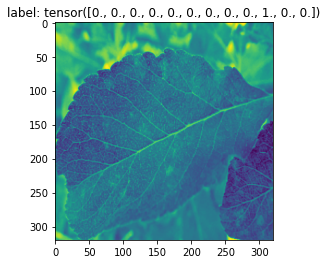

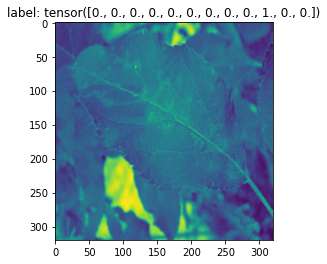

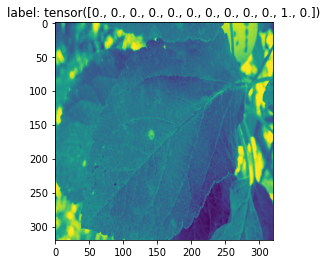

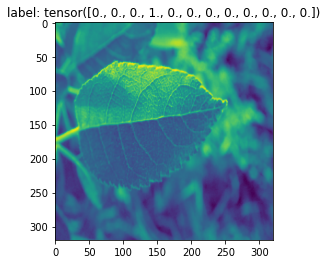

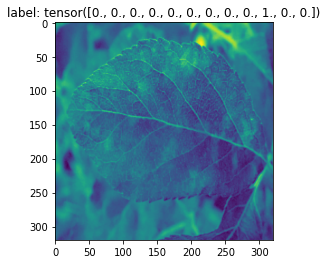

In [20]:
for i in range(5):
    image, label = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f'label: {label}')
    plt.show() 

In [21]:
class EfficientNetB4(nn.Module):
    """
        Base class for all neural network modules.
        Your models should also subclass this class.
        Modules can also contain other Modules, allowing to nest them in a tree structure.
        You can assign the submodules as regular attributes:
    """
    def __init__(self):
        super().__init__()
        self.efficientnetb4 = timm.create_model(model_name = CFG['model_arch'],pretrained = False)
        n_features = self.efficientnetb4.classifier.in_features
        self.efficientnetb4.classifier = nn.Linear(n_features, len(TARGET_COLUMNS))#(input_size,output_size)
        
    def forward(self, x):
        x = self.efficientnetb4(x)
        return x
    
model = EfficientNetB4()
model = model.to(DEVICE)
print(DEVICE)

cuda


In [22]:
with timer('training'):
    
    model = EfficientNetB4().to(DEVICE)

    #criterion:LogisticLoss
    criterion = nn.BCEWithLogitsLoss()
    #optimizer:Adam
    optimizer = torch.optim.Adam(model.parameters())

    best_loss = np.inf
    for epoch in range(CFG['epochs']):
            model.train()
            for X, y in train_loader:
                optimizer.zero_grad()
                X = X.float().to(DEVICE) #shape(16,3,320,320)
                y = y.float().to(DEVICE) #shape(16,12)
                pred = model(X)          #shape(16,12)
                #print(X.shape, y.shape, pred.shape)
                loss = criterion(pred, y)
                """
                    >>> target = torch.ones([10, 64], dtype=torch.float32)  # 64 classes, batch size = 10
                    >>> output = torch.full([10, 64], 1.5)  # A prediction (logit)
                    >>> pos_weight = torch.ones([64])  # All weights are equal to 1
                    >>> criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
                    >>> criterion(output, target)  # -log(sigmoid(1.5)),tensor(0.2014)
                    
                    Input: (N, *)(N,∗) where *∗ means, any number of additional dimensions
                    Target: (N, *)(N,∗), same shape as the input
                    Output: scalar. If reduction is 'none', then (N, *)(N,∗), same shape as input.
                """
                loss.backward()
                optimizer.step()
            model.eval()
            valid_loss = 0
            with torch.no_grad():
                for X, y in valid_loader:
                    X = X.float().to(DEVICE)
                    y = y.float().to(DEVICE)
                    pred = model(X)
                    loss = criterion(pred, y)
                    valid_loss += loss.item()
            valid_loss /= len(valid_loader)
            print(f"EPOCH:{epoch}, Loss:{valid_loss}")
            if valid_loss < best_loss:
                best_loss = valid_loss
                torch.save(model.state_dict(), "MyEfficientNetb4.pth")
                print("saved")


[training] start
EPOCH:0, Loss:0.6237829956462828
saved
EPOCH:1, Loss:0.6402239665641623
EPOCH:2, Loss:0.2543032103675907
saved
EPOCH:3, Loss:0.2866615352489181
EPOCH:4, Loss:0.205266161995419
saved
[training] done in 2901 s


In [23]:
model = EfficientNetB4().to(DEVICE)
model.load_state_dict(torch.load("./MyEfficientNetb4.pth"))

<All keys matched successfully>

In [24]:
test_dataset = TestDataset(sub_df, transform = get_transforms(data='valid'))
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [25]:
submit_preds = []

model.eval()
with torch.no_grad():
    for X in test_loader:
        X = X.float().to(DEVICE)
        submit_preds.append(model(X).sigmoid().to("cpu"))
    submit_preds = np.concatenate([p.numpy() for p in submit_preds], axis = 0)
submit_preds

array([[2.1293143e-02, 3.2365783e-03, 1.3059309e-04, 7.0144528e-01,
        1.4723599e-03, 5.1596208e-04, 1.7356290e-02, 6.6094610e-05,
        6.4904371e-04, 1.4328976e-01, 7.1485766e-04, 8.0940754e-06],
       [2.1756454e-01, 6.8389320e-01, 2.3344411e-02, 1.8005377e-03,
        5.2802186e-03, 5.9181469e-04, 1.1203962e-01, 2.3175748e-03,
        6.5723048e-03, 1.6344398e-02, 7.4518047e-02, 8.8320719e-03],
       [7.2716132e-02, 3.6131507e-01, 4.1976050e-03, 3.3690291e-03,
        5.1927788e-04, 1.2972011e-04, 5.6685555e-01, 2.7103296e-03,
        1.1099123e-02, 1.3476133e-02, 2.7700083e-02, 7.9710816e-04]],
      dtype=float32)

In [26]:
s = pd.DataFrame(submit_preds)
s

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.021293,0.003237,0.000131,0.701445,0.001472,0.000516,0.017356,0.000066,0.000649,0.143290,0.000715,0.000008
1,0.217565,0.683893,0.023344,0.001801,0.005280,0.000592,0.112040,0.002318,0.006572,0.016344,0.074518,0.008832
2,0.072716,0.361315,0.004198,0.003369,0.000519,0.000130,0.566856,0.002710,0.011099,0.013476,0.027700,0.000797


In [27]:
tmp = np.concatenate([sub_df, s], axis = 1)
tmp = pd.DataFrame(tmp)
tmp = tmp.drop([1], axis=1)
tmp.columns = TARGET
tmp

,image,healthy,scab frog_eye_leaf_spot complex,scab,complex,rust,frog_eye_leaf_spot,powdery_mildew,scab frog_eye_leaf_spot,frog_eye_leaf_spot complex,rust frog_eye_leaf_spot,powdery_mildew complex,rust complex
0,85f8cb619c66b863.jpg,0.0212931,0.00323658,0.000130593,0.701445,0.00147236,0.000515962,0.0173563,6.60946e-05,0.000649044,0.14329,0.000714858,8.09408e-06
1,ad8770db05586b59.jpg,0.217565,0.683893,0.0233444,0.00180054,0.00528022,0.000591815,0.11204,0.00231757,0.0065723,0.0163444,0.074518,0.00883207
2,c7b03e718489f3ca.jpg,0.0727161,0.361315,0.0041976,0.00336903,0.000519278,0.00012972,0.566856,0.00271033,0.0110991,0.0134761,0.0277001,0.000797108


In [28]:
tmp = tmp.iloc[0:,1:].astype(float)
tmp.dtypes

healthy                            float64
scab frog_eye_leaf_spot complex    float64
scab                               float64
complex                            float64
rust                               float64
frog_eye_leaf_spot                 float64
powdery_mildew                     float64
scab frog_eye_leaf_spot            float64
frog_eye_leaf_spot complex         float64
rust frog_eye_leaf_spot            float64
powdery_mildew complex             float64
rust complex                       float64
dtype: object

In [29]:
tmp

,healthy,scab frog_eye_leaf_spot complex,scab,complex,rust,frog_eye_leaf_spot,powdery_mildew,scab frog_eye_leaf_spot,frog_eye_leaf_spot complex,rust frog_eye_leaf_spot,powdery_mildew complex,rust complex
0,0.021293,0.003237,0.000131,0.701445,0.001472,0.000516,0.017356,0.000066,0.000649,0.143290,0.000715,0.000008
1,0.217565,0.683893,0.023344,0.001801,0.005280,0.000592,0.112040,0.002318,0.006572,0.016344,0.074518,0.008832
2,0.072716,0.361315,0.004198,0.003369,0.000519,0.000130,0.566856,0.002710,0.011099,0.013476,0.027700,0.000797


In [30]:
target = tmp.iloc[0:,1:].idxmax(axis = 1)
target

0                            complex
1    scab frog_eye_leaf_spot complex
2                     powdery_mildew
dtype: object

In [31]:
s = pd.DataFrame(target)
s

,0
0,complex
1,scab frog_eye_leaf_spot complex
2,powdery_mildew


In [32]:
tmp2 = np.concatenate([sub_df, s], axis = 1)
tmp2 = pd.DataFrame(tmp2)
tmp2 = tmp2.drop([1], axis=1)
tmp2 = tmp2.set_axis(SUB_LABELS, axis = 1)
tmp2

,image,labels
0,85f8cb619c66b863.jpg,complex
1,ad8770db05586b59.jpg,scab frog_eye_leaf_spot complex
2,c7b03e718489f3ca.jpg,powdery_mildew


In [33]:
sub = tmp2.to_csv("submission.csv",index = False)

In [34]:
sub = pd.read_csv('./submission.csv')
sub

,image,labels
0,85f8cb619c66b863.jpg,complex
1,ad8770db05586b59.jpg,scab frog_eye_leaf_spot complex
2,c7b03e718489f3ca.jpg,powdery_mildew


In [35]:
print(sub_df.shape, sub.shape)

(3, 2) (3, 2)
